# Data exploration

Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [10]:
symbols = pd.read_csv("data/files/symbols_valid_meta.csv")
# On filtre pour le plus avoir les ETF
symbols = symbols[symbols['ETF'] == 'N']
symbols.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
5,Y,AAL,"American Airlines Group, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,AAL,N
6,Y,AAMC,Altisource Asset Management Corp Com,A,,N,100.0,N,NaN,AAMC,AAMC,N


In [11]:
# On recupere les données sur le market category
symbols['Market Category'].value_counts()

Market Category
     2896
Q    1531
S     952
G     505
Name: count, dtype: int64

In [12]:
# On ne s'intéresse qu'au 'G'
filtered_data = symbols[symbols['Market Category'] == 'G']
available_symbols = filtered_data['Symbol'].tolist()
filtered_data.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
7,Y,AAME,Atlantic American Corporation - Common Stock,Q,G,N,100.0,N,N,NaN,AAME,N
9,Y,AAOI,"Applied Optoelectronics, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,AAOI,N
32,Y,ABTX,"Allegiance Bancshares, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,ABTX,N
54,Y,ACIU,AC Immune SA - Common Stock,Q,G,N,100.0,N,N,NaN,ACIU,N


## Stock File reading And feature computing

We compute the features for our models. In the same time, we filter the stocks to only keep the ones that have at least 6000 observations.

In [13]:
def compute_features(df, windows = [5, 10, 20, 50]):
    
    features = pd.DataFrame(index=df.index)
    
    # Basic Features 
    
    # Returns (our target and a feature)
    features['returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    
    # Intraday features
    features['hl_range'] = (df['High'] - df['Low']) / df['Close']
    features['oc_range'] = (df['Close'] - df['Open']) / df['Open']
    features['overnight_gap'] = (df['Open'] - df['Adj Close'].shift(1)) / df['Adj Close'].shift(1)
    
    # Volume (handle zero volumes to avoid log(0) warnings)
    volume_ratio = df['Volume'] / df['Volume'].shift(1)
    # Replace zero or inf values before taking log
    volume_ratio = volume_ratio.replace([0, np.inf, -np.inf], np.nan)
    features['volume_change'] = np.log(volume_ratio)
    # Fill NaN with 0 (no volume change)
    features['volume_change'] = features['volume_change'].fillna(0)
    
    # Rolling Window Features
    
    for window in windows:
        # Price vs Moving Average
        ma = df['Close'].rolling(window).mean()
        features[f'price_vs_ma{window}'] = (df['Close'] - ma) / ma
        
        # Volume vs Moving Average (handle zero MA)
        vol_ma = df['Volume'].rolling(window).mean()
        # Avoid division by zero
        vol_ma_safe = vol_ma.replace(0, np.nan)
        features[f'volume_vs_ma{window}'] = (df['Volume'] - vol_ma) / vol_ma_safe
        features[f'volume_vs_ma{window}'] = features[f'volume_vs_ma{window}'].fillna(0)
        
        # Volatility (realized)
        features[f'volatility_{window}'] = features['returns'].rolling(window).std()
        
        # Momentum (rate of change)
        features[f'momentum_{window}'] = df['Close'].pct_change(window, fill_method=None)
        
        # Return statistics
        features[f'return_mean_{window}'] = features['returns'].rolling(window).mean()
        features[f'return_std_{window}'] = features['returns'].rolling(window).std()
        features[f'return_skew_{window}'] = features['returns'].rolling(window).skew()
        
        # High-Low volatility
        features[f'hl_volatility_{window}'] = features['hl_range'].rolling(window).mean()
    
    # Moving Average Crossovers
    
    # Short MA vs Long MA
    features['ma_cross_5_20'] = (df['Close'].rolling(5).mean() - df['Close'].rolling(20).mean()) / df['Close']
    features['ma_cross_10_50'] = (df['Close'].rolling(10).mean() - df['Close'].rolling(50).mean()) / df['Close']
    
    # Relative Positions
    
    # Where is price relative to recent high/low
    for window in [5, 20, 50]:
        high = df['High'].rolling(window).max()
        low = df['Low'].rolling(window).min()
        features[f'price_position_{window}'] = (df['Close'] - low) / (high - low + 1e-10)
    
    # Trend Features
    
    # Linear trend strength over different windows
    for window in [10, 20, 50]:
        # Simple trend: compare first and last in window
        features[f'trend_{window}'] = (df['Close'] - df['Close'].shift(window)) / df['Close'].shift(window)
    
    # Drop NaN values
    features = features.dropna()
    
    return features

In [ ]:
# Configuration
max_stocks = None  # Start with 50 stocks (much faster than transformer!)
windows = [5, 10, 20, 50]  # Rolling window sizes
verbose = True
symbols=available_symbols[:max_stocks]

data_dir = Path('data/files/stocks')

if max_stocks:
    symbols = symbols[:max_stocks]

all_features = []
all_targets = []
all_symbols = []

for idx, symbol in enumerate(symbols):
    file_path = data_dir / f"{symbol}.csv"
    
    if not file_path.exists():
        continue
    
    try:
        # Read data
        df = pd.read_csv(file_path)
        
        # Compute features
        features = compute_features(df, windows=windows)
        
        if len(features) < 6000:  # Skip stocks with too little data
            continue
        
        # Target is next day's return (shift -1)
        target = features['returns'].shift(-1)
        
        # Remove last row (no target available)
        features = features[:-1]
        target = target[:-1]
        
        all_features.append(features)
        all_targets.append(target)
        all_symbols.extend([symbol] * len(features))
        
        if verbose and (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(symbols)} stocks...")
            
    except Exception as e:
        if verbose:
            print(f"Error loading {symbol}: {e}")
        continue

# Combine all stocks
X = pd.concat(all_features, axis=0).reset_index(drop=True)
y = pd.concat(all_targets, axis=0).reset_index(drop=True)

if verbose:
    print(f"\nLoaded {len(all_features)} stocks")
    print(f"Total samples: {len(X)}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Feature names: {X.columns.tolist()[:10]}... (showing first 10)")

### Data splitting

In [15]:
train_ratio = 0.7
val_ratio = 0.15
# Test ratio is implicit: 0.15

n = len(X)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

X_train = X[:train_end]
X_val = X[train_end:val_end]
X_test = X[val_end:]

y_train = y[:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

print("Data Split (Temporal):")
print(f"  Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Check target distribution
print(f"\nTarget (returns) statistics:")
print(f"  Train - Mean: {y_train.mean():.6f}, Std: {y_train.std():.6f}")
print(f"  Val   - Mean: {y_val.mean():.6f}, Std: {y_val.std():.6f}")
print(f"  Test  - Mean: {y_test.mean():.6f}, Std: {y_test.std():.6f}")

Data Split (Temporal):
  Train: 464,799 samples (70.0%)
  Val:   99,600 samples (15.0%)
  Test:  99,600 samples (15.0%)

Target (returns) statistics:
  Train - Mean: 0.000105, Std: 0.040514
  Val   - Mean: 0.000220, Std: 0.038854
  Test  - Mean: 0.000036, Std: 0.039737


# LGBM

## LGBM Training

LGBM training function

In [24]:
import lightgbm as lgb

def train_lgbm_model(X_train, y_train, X_val, y_val, num_boost_round = 500, verbose = True):

    # Default parameters optimized for stock prediction
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'min_child_samples': 20,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    }
    
    # Create datasets
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    # Train
    if verbose:
        print("Training LGBM model...")
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(period=50 if verbose else 0)
        ]
    )
    
    if verbose:
        print(f"\nBest iteration: {model.best_iteration}")
        print(f"Best score: {model.best_score['valid']['rmse']:.6f}")
    
    return model

In [25]:
# Train with default parameters
print("Training baseline LGBM model...")
print("This should take 1-3 minutes on CPU...")
print()

model = train_lgbm_model(
    X_train, y_train,
    X_val, y_val,
    verbose=True
)

print("\nTraining complete!")

model.save_model('lgbm_model.txt')
print("Model saved to lgbm_model.txt")

Training baseline LGBM model...
This should take 1-3 minutes on CPU...

Training LGBM model...
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.0391577	valid's rmse: 0.0380023
[100]	train's rmse: 0.0387435	valid's rmse: 0.0379516
Early stopping, best iteration is:
[95]	train's rmse: 0.0387743	valid's rmse: 0.0379447

Best iteration: 95
Best score: 0.037945

Training complete!
Model saved to lgbm_model.txt


## LGBM Model evaluation

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_lgbm_model(model, X_test, y_test, verbose = True):

    # Predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # Regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Directional accuracy (most important for trading!)
    pred_direction = np.sign(y_pred)
    true_direction = np.sign(y_test)
    directional_accuracy = np.mean(pred_direction == true_direction)
    
    # Strategy performance (simplified)
    strategy_returns = y_test.values * pred_direction
    cumulative_return = np.sum(strategy_returns)
    sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-10) * np.sqrt(252)
    
    metrics = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'directional_accuracy': directional_accuracy,
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio
    }
    
    if verbose:
        print("\n" + "="*50)
        print("MODEL EVALUATION METRICS")
        print("="*50)
        print(f"MSE:                    {mse:.6f}")
        print(f"MAE:                    {mae:.6f}")
        print(f"RMSE:                   {rmse:.6f}")
        print(f"Directional Accuracy:   {directional_accuracy:.4f} ({directional_accuracy*100:.2f}%)")
        print(f"Cumulative Return:      {cumulative_return:.6f}")
        print(f"Sharpe Ratio:           {sharpe_ratio:.4f}")
        print("="*50)
    
    return metrics

In [27]:
# Comprehensive evaluation
metrics = evaluate_lgbm_model(
    model,
    X_test,
    y_test,
    verbose=True
)

# Additional analysis
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print("\\nAdditional Statistics:")
print(f"  Predictions - Mean: {y_pred.mean():.6f}, Std: {y_pred.std():.6f}")
print(f"  Correlation (pred vs actual): {np.corrcoef(y_pred, y_test)[0,1]:.4f}")


MODEL EVALUATION METRICS
MSE:                    0.001525
MAE:                    0.023010
RMSE:                   0.039052
Directional Accuracy:   0.4178 (41.78%)
Cumulative Return:      417.385462
Sharpe Ratio:           1.6835
\nAdditional Statistics:
  Predictions - Mean: 0.000184, Std: 0.007456
  Correlation (pred vs actual): 0.1850


## Feature analysis

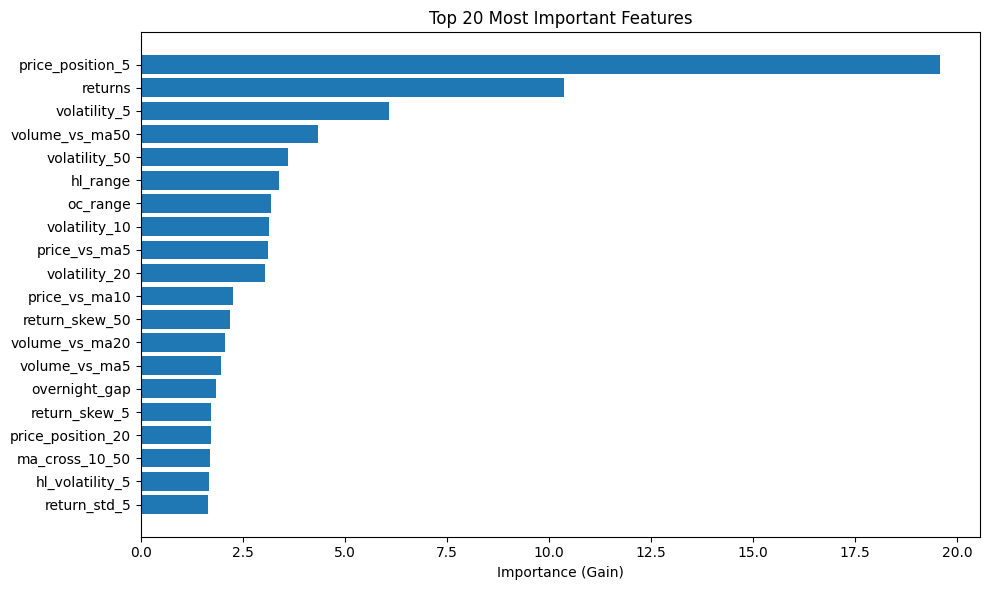

In [28]:
top_n = 20

# Get importance
importance = model.feature_importance(importance_type='gain')
feature_names = X.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Normalize
importance_df['importance_pct'] = importance_df['importance'] / importance_df['importance'].sum() * 100

plt.figure(figsize=(10, max(6, top_n * 0.3)))
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance_pct'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Visualize LGBM model predictions

In [29]:
def plot_predictions_vs_actuals(y_true, y_pred, title = "Predictions vs Actuals"):
    """Plot predictions vs actual values"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.1, s=1)
    axes[0, 0].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', label='Perfect Prediction')
    axes[0, 0].set_xlim(-0.5, 0.5)
    axes[0, 0].set_ylim(-0.5, 0.5)
    axes[0, 0].set_xlabel('Actual Returns')
    axes[0, 0].set_ylabel('Predicted Returns')
    axes[0, 0].set_title('Predictions vs Actuals')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.1, s=1)
    axes[0, 1].set_xlim(-0.5, 0.5)
    axes[0, 1].set_ylim(-0.5, 0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Returns')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Distribution comparison
    axes[1, 0].hist(y_pred, bins=50, alpha=0.7, label='Predictions', density=True)
    axes[1, 0].hist(y_true, bins=50, alpha=0.7, label='Actuals', density=True)
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Cumulative returns using predictions
    pred_direction = np.sign(y_pred)
    strategy_returns = y_true.values * pred_direction
    cumulative_returns = np.cumsum(strategy_returns)
    
    axes[1, 1].plot(cumulative_returns)
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Trade Number')
    axes[1, 1].set_ylabel('Cumulative Return')
    axes[1, 1].set_title('Cumulative Returns (Trading Strategy)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

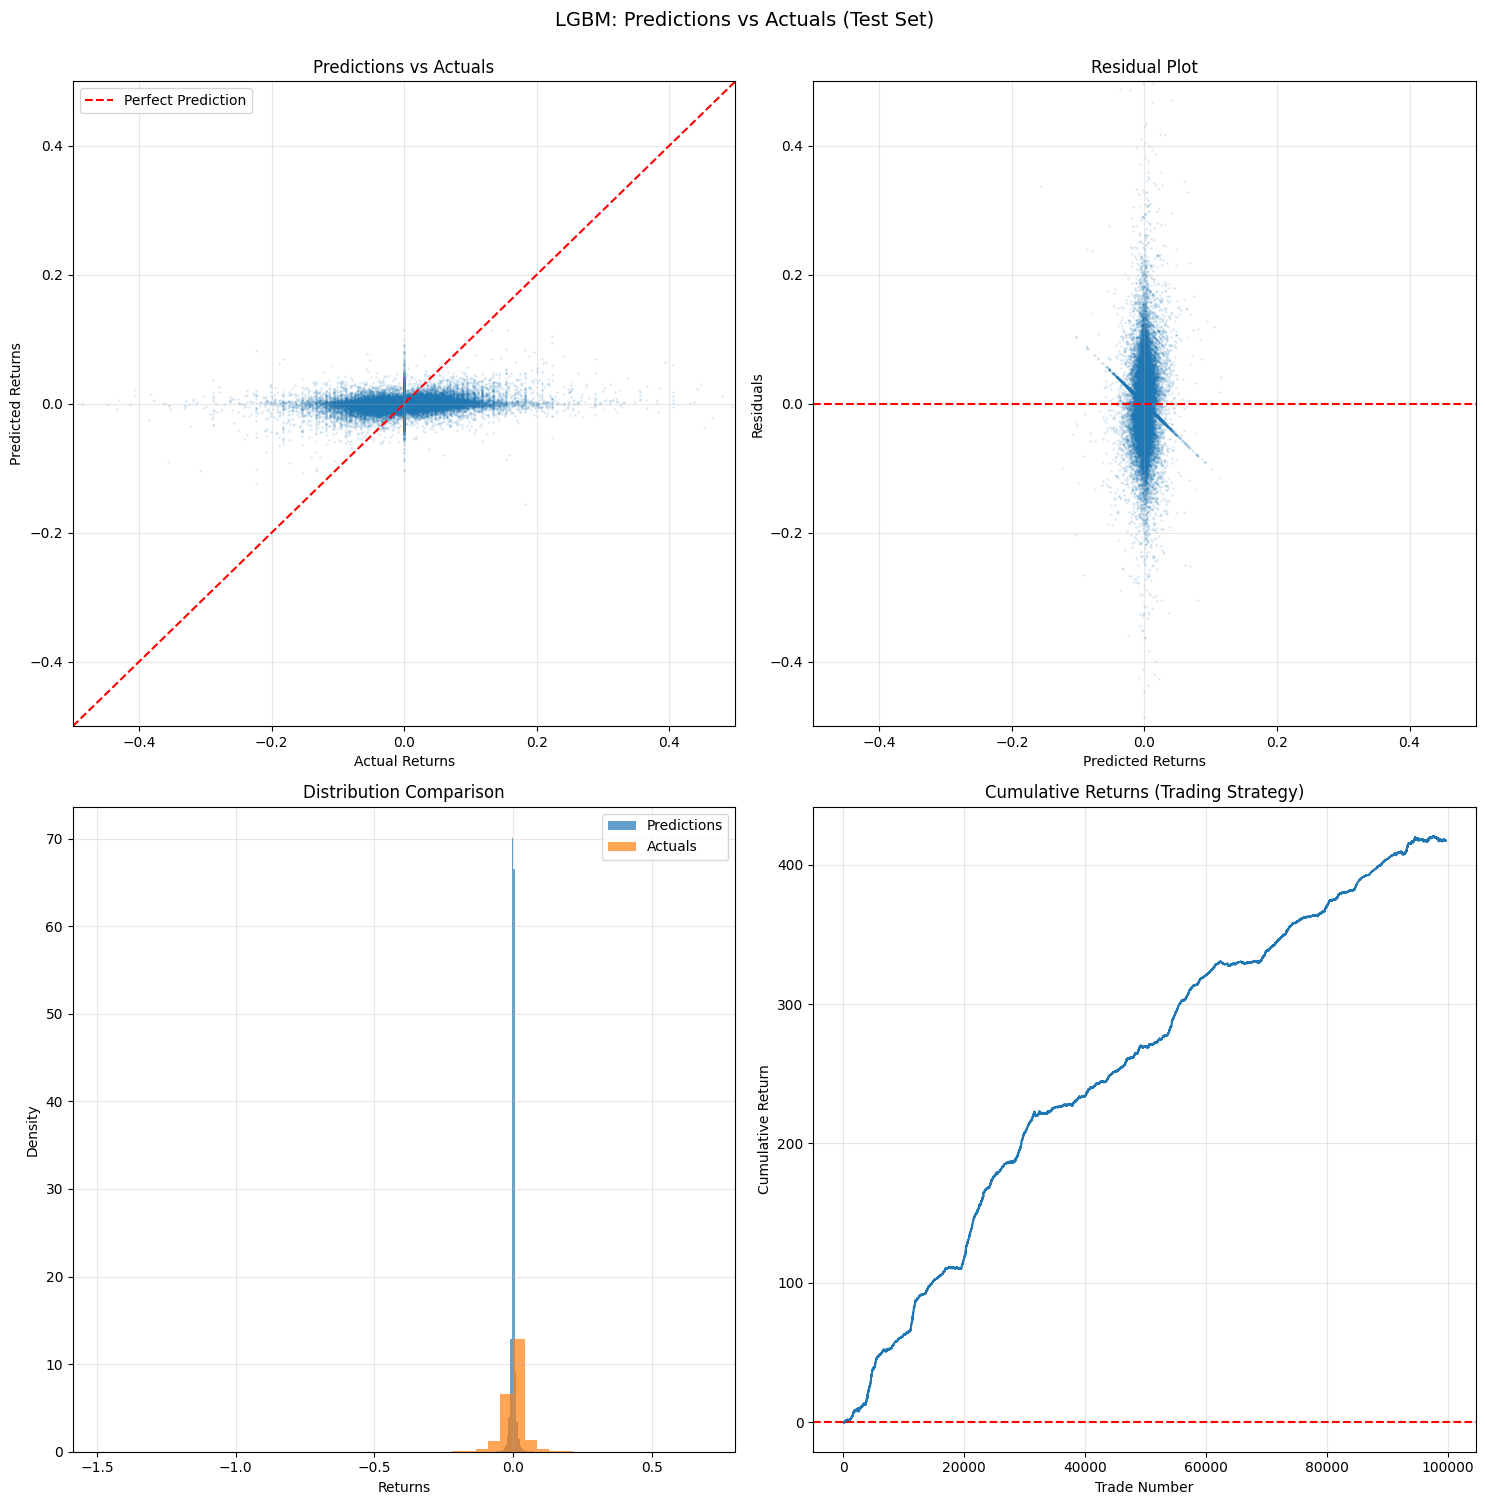

In [30]:
# Comprehensive visualization
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

plot_predictions_vs_actuals(
    y_test,
    y_pred,
    title="LGBM: Predictions vs Actuals (Test Set)"
)

# Random Forest

## Train Random Forest Model

In [15]:
from sklearn.ensemble import RandomForestRegressor

def train_rf_model(X_train, y_train, X_val, y_val):
    
    # Default parameters optimized for stock prediction

    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 20,
        'min_samples_leaf': 10,
        'max_features': 'sqrt',
        'random_state': 42,
        'n_jobs': -1,  # Use all CPU cores
        'verbose': 0
    }

    print("Training Random Forest model...")
    print(f"Parameters: {params}")
    
    # Clean data: Replace inf and NaN values
    X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_val_clean = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Train
    model = RandomForestRegressor(**params)
    model.fit(X_train_clean, y_train)

    # Evaluate on train and validation
    train_pred = model.predict(X_train_clean)
    val_pred = model.predict(X_val_clean)
    
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    
    print(f"\nTraining complete!")
    print(f"  Train RMSE: {np.sqrt(train_mse):.6f}")
    print(f"  Val RMSE:   {np.sqrt(val_mse):.6f}")
    
    return model

In [16]:
import joblib

# Train with default parameters
print("Training baseline Random Forest model...")
print("This should take 2-5 minutes on CPU...")
print()

model = train_rf_model(
    X_train, y_train,
    X_val, y_val,
)

print("\n Training complete!")

def save_rf_model(model, filename):
    """Save Random Forest model"""
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

save_rf_model(model, 'rf_model.pkl')

# Function to load model
def load_rf_model(filename):
    """Load Random Forest model"""
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

Training baseline Random Forest model...
This should take 2-5 minutes on CPU...

Training Random Forest model...
Parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1, 'verbose': 0}

Training complete!
  Train RMSE: 0.178318
  Val RMSE:   0.035106

 Training complete!
Model saved to rf_model.pkl


## Evaluate Random Forest Model

In [17]:
def evaluate_rf_model(model, X_test, y_test):
    
    # Clean test data (same as training)
    X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Predictions
    y_pred = model.predict(X_test_clean)
    
    # Regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Directional accuracy (most important for trading!)
    pred_direction = np.sign(y_pred)
    true_direction = np.sign(y_test)
    directional_accuracy = np.mean(pred_direction == true_direction)
    
    # Strategy performance (simplified)
    strategy_returns = y_test.values * pred_direction
    cumulative_return = np.sum(strategy_returns)
    sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-10) * np.sqrt(252)
    
    metrics = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'directional_accuracy': directional_accuracy,
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio
    }
    
    print("\n" + "="*50)
    print("MODEL EVALUATION METRICS")
    print("="*50)
    print(f"MSE:                    {mse:.6f}")
    print(f"MAE:                    {mae:.6f}")
    print(f"RMSE:                   {rmse:.6f}")
    print(f"Directional Accuracy:   {directional_accuracy:.4f} ({directional_accuracy*100:.2f}%)")
    print(f"Cumulative Return:      {cumulative_return:.6f}")
    print(f"Sharpe Ratio:           {sharpe_ratio:.4f}")
    print("="*50)
    
    return metrics

In [18]:
# Comprehensive evaluation
metrics = evaluate_rf_model(
    model,
    X_test,
    y_test
)

# Additional analysis
# Clean data for manual prediction
X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
y_pred = model.predict(X_test_clean)

print("\nAdditional Statistics:")
print(f"  Predictions - Mean: {y_pred.mean():.6f}, Std: {y_pred.std():.6f}")
print(f"  Correlation (pred vs actual): {np.corrcoef(y_pred, y_test)[0,1]:.4f}")


MODEL EVALUATION METRICS
MSE:                    0.002127
MAE:                    0.021967
RMSE:                   0.046123
Directional Accuracy:   0.4529 (45.29%)
Cumulative Return:      55.828623
Sharpe Ratio:           0.7015

Additional Statistics:
  Predictions - Mean: -0.000563, Std: 0.008147
  Correlation (pred vs actual): 0.2889


## Feature Analysis

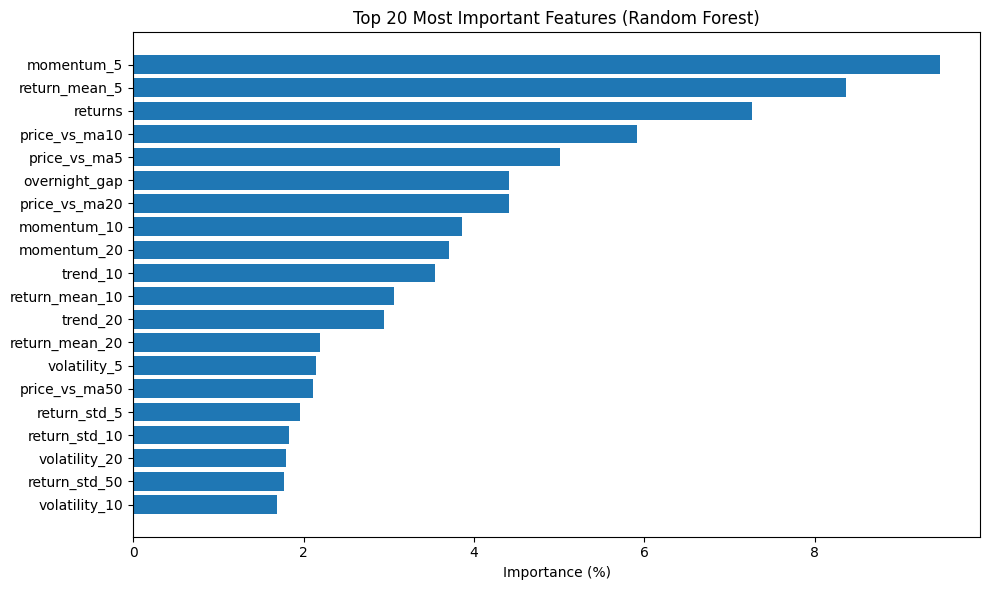

In [19]:
top_n = 20
# Get importance
importance = model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Normalize
importance_df['importance_pct'] = importance_df['importance'] / importance_df['importance'].sum() * 100

plt.figure(figsize=(10, max(6, top_n * 0.3)))
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance_pct'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (%)')
plt.title(f'Top {top_n} Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Visualize RF model predictions

In [20]:
def plot_predictions_vs_actuals_rf(y_true, y_pred, title = "Random Forest: Predictions vs Actuals"):

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.1, s=1)
    axes[0, 0].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', label='Perfect Prediction')
    axes[0, 0].set_xlim(-0.5, 0.5)
    axes[0, 0].set_ylim(-0.5, 0.5)
    axes[0, 0].set_xlabel('Actual Returns')
    axes[0, 0].set_ylabel('Predicted Returns')
    axes[0, 0].set_title('Predictions vs Actuals')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.1, s=1)
    axes[0, 1].set_xlim(-0.5, 0.5)
    axes[0, 1].set_ylim(-0.5, 0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Returns')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Distribution comparison
    axes[1, 0].hist(y_pred, bins=50, alpha=0.7, label='Predictions', density=True)
    axes[1, 0].hist(y_true, bins=50, alpha=0.7, label='Actuals', density=True)
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Cumulative returns using predictions
    pred_direction = np.sign(y_pred)
    strategy_returns = y_true.values * pred_direction
    cumulative_returns = np.cumsum(strategy_returns)
    
    axes[1, 1].plot(cumulative_returns)
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Trade Number')
    axes[1, 1].set_ylabel('Cumulative Return')
    axes[1, 1].set_title('Cumulative Returns (Trading Strategy)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

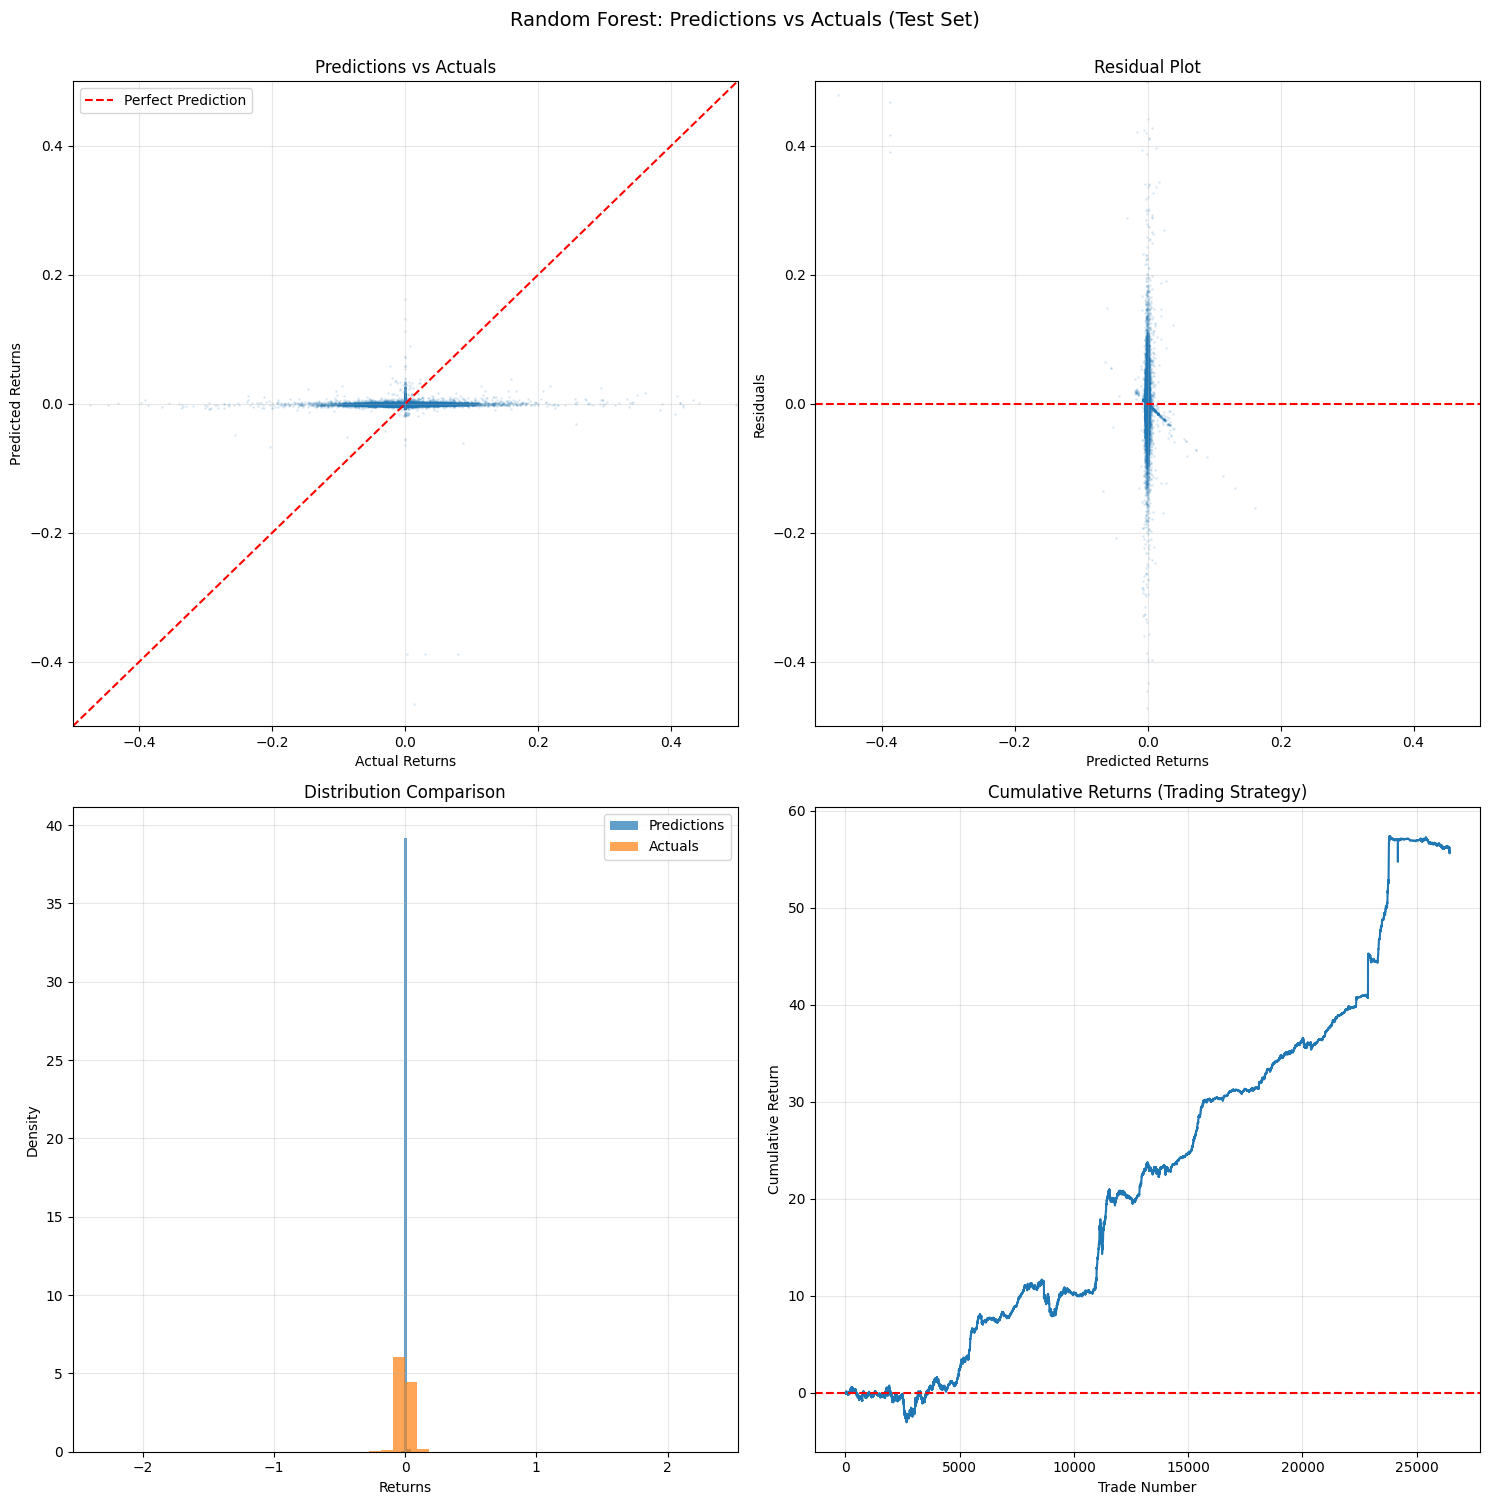

In [21]:
# Comprehensive visualization
X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
y_pred = model.predict(X_test_clean)

plot_predictions_vs_actuals_rf(
    y_test,
    y_pred,
    title="Random Forest: Predictions vs Actuals (Test Set)"
)

# Simple Neural Network (MLP)

## Model

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



class SimpleMLP(nn.Module):
    """
    Simple Multi-Layer Perceptron
    
    Architecture:
    Input -> [Linear -> ReLU -> BatchNorm -> Dropout] x N -> Linear -> Output
    """
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super(SimpleMLP, self).__init__()
        
        layers = []
        curr_dim = input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(curr_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.Dropout(dropout_rate))
            curr_dim = h_dim
            
        # Output layer (regression)
        layers.append(nn.Linear(curr_dim, 1))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Training MLP model

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


def train_mlp_model(X_train, y_train, X_val, y_val, params=None):
    """
    Train MLP model with feature scaling and early stopping
    
    Returns:
        model: Trained PyTorch model
        scaler: Fitted StandardScaler
        train_losses: History of training losses
        val_losses: History of validation losses
    """
    # Default parameters
    if params is None:
        params = {
            'hidden_dims': [256, 128, 64],
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'batch_size': 64,
            'epochs': 50,
            'patience': 10  # Early stopping patience
        }

    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    
    print("Training Simple MLP model...")
    print(f"Parameters: {params}")
    print(f"Device: {device}")
    
    # 1. Clean Data
    print("Cleaning data...")
    X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_val_clean = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # 2. Scale Data (Critical for Neural Networks!)
    print(f"Scaling data (Shape: {X_train_clean.shape})...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_val_scaled = scaler.transform(X_val_clean)
    
    # 3. Convert to Tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
    y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1).to(device)
    
    # 4. Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size', 64), shuffle=True)
    
    # 5. Initialize Model
    input_dim = X_train.shape[1]
    model = SimpleMLP(
        input_dim=input_dim,
        hidden_dims=params.get('hidden_dims', [256, 128, 64]),
        dropout_rate=params.get('dropout_rate', 0.2)
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params.get('learning_rate', 0.001))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # 6. Training Loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    epochs = params.get('epochs', 50)
    
    for epoch in range(epochs):
        # Train
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)
        
        # Scheduler step
        scheduler.step(val_loss)
        
        # Early Stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train MSE: {avg_train_loss:.6f} | Val MSE: {val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if patience_counter >= params.get('patience', 10):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, scaler, train_losses, val_losses

In [ ]:
# Train with default parameters
print("="*60)
print("Training Simple MLP Model")
print("="*60)
print()

# Custom parameters for Neural Net
params = {
    'hidden_dims': [128, 64, 32],  # Simple 3-layer network
    'dropout_rate': 0.2,           # Prevent overfitting
    'learning_rate': 0.001,
    'batch_size': 128,
    'epochs': 10
}

# Returns model, scaler, and loss history
model, scaler, train_losses, val_losses = train_mlp_model(
    X_train, y_train,
    X_val, y_val,
    params=params
)

# Plot Loss History
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nTraining complete!")

def save_mlp_model(model, scaler, filename = 'mlp_model.pth'):
    """Save model and scaler"""
    state = {
        'model_state': model.state_dict(),
        'scaler': scaler,
        'input_dim': model.model[0].in_features  # Save dimensions to rebuild
    }
    torch.save(state, filename)
    print(f"✓ Model saved to {filename}")

save_mlp_model(model, scaler)

Training Simple MLP Model

Training Simple MLP model...
Parameters: {'hidden_dims': [128, 64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 10}
Device: mps
Cleaning data...
Scaling data (Shape: (123442, 45))...


## Model Evaluation

In [ ]:
def evaluate_mlp_model(model, scaler, X_test, y_test):

    model.eval()
    
    # Clean and Scale
    X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test_scaled = scaler.transform(X_test_clean)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    
    # Predict
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.cpu().numpy().flatten()
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Directional Accuracy
    pred_direction = np.sign(y_pred)
    true_direction = np.sign(y_test)
    directional_accuracy = np.mean(pred_direction == true_direction)
    
    # Strategy Returns (simple long/short)
    strategy_returns = y_test.values * pred_direction
    cumulative_return = np.sum(strategy_returns)
    sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-10) * np.sqrt(252)
    
    metrics = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'directional_accuracy': directional_accuracy,
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio
    }
    
    print("\n" + "="*50)
    print("MLP MODEL EVALUATION")
    print("="*50)
    print(f"MSE:                    {mse:.6f}")
    print(f"RMSE:                   {rmse:.6f}")
    print(f"Directional Accuracy:   {directional_accuracy:.4f} ({directional_accuracy*100:.2f}%)")
    print(f"Sharpe Ratio:           {sharpe_ratio:.4f}")
    print("="*50)
        
    return metrics

In [ ]:
# Comprehensive evaluation
metrics = evaluate_mlp_model(
    model,
    scaler,
    X_test,
    y_test,
    verbose=True
)

# Get predictions
model.eval()
X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_scaled = scaler.transform(X_test_clean)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(model.model[0].weight)

with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy().flatten()

print("\\nAdditional Statistics:")
print(f"  Predictions - Mean: {y_pred.mean():.6f}, Std: {y_pred.std():.6f}")
print(f"  Correlation: {np.corrcoef(y_pred, y_test)[0,1]:.4f}")

## Visualize predictions

In [ ]:
plot_predictions_vs_actuals_rf(y_test, y_pred, "MLP: Predictions vs Actuals")

# SVR

## Train SVR Model

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def train_svm_model(X_train, y_train, X_val, y_val):

    # Default parameters optimized for stock prediction
    params = {
        'kernel': 'rbf',  # Radial basis function
        'C': 1.0,  # Regularization
        'epsilon': 0.01,  # Epsilon tube
        'gamma': 'scale',  # Kernel coefficient
        'cache_size': 1000,  # Cache size in MB
        'verbose': False
    }
    
    print("Training SVM (SVR) model...")
    print(f"Parameters: {params}")
    print("Note: SVM requires feature scaling...")
    
    # Clean data: Replace inf and NaN values
    X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_val_clean = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # CRITICAL: SVM requires feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_val_scaled = scaler.transform(X_val_clean)
    
    # Train
    model = SVR(**params)
    

    print("Fitting model (this may take 5-15 minutes for large datasets)...")
    
    model.fit(X_train_scaled, y_train)
    

    # Evaluate on train and validation
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    
    print(f"\nTraining complete!")
    print(f"  Train RMSE: {np.sqrt(train_mse):.6f}")
    print(f"  Val RMSE:   {np.sqrt(val_mse):.6f}")
    print(f"  Number of support vectors: {len(model.support_)}")
    
    return model, scaler

In [ ]:
# Train with default parameters
print("="*60)
print("Training SVM (SVR) model...")
print("="*60)
print()

# SVM returns both model and scaler (scaler is needed for predictions!)
model, scaler = train_svm_model(
    X_train, y_train,
    X_val, y_val
)

print("\n Training complete!")

def save_svm_model(model, scaler, filename):
    """Save SVM model and scaler"""
    joblib.dump({'model': model, 'scaler': scaler}, filename)
    print(f"Model and scaler saved to {filename}")

save_svm_model(model, scaler, 'svm_model.joblib')

# Function to load model
def load_svm_model(filename):
    """Load SVM model and scaler"""
    data = joblib.load(filename)
    print(f"Model and scaler loaded from {filename}")
    return data['model'], data['scaler']

Training SVM (SVR) model...

Training SVM (SVR) model...
Parameters: {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.01, 'gamma': 'scale', 'cache_size': 1000, 'verbose': False}
Note: SVM requires feature scaling...
Fitting model (this may take 5-15 minutes for large datasets)...


## Model Evaluation

In [ ]:
def evaluate_svm_model(model, scaler, X_test, y_test):

    # Clean and scale test data
    X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test_scaled = scaler.transform(X_test_clean)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Directional accuracy
    pred_direction = np.sign(y_pred)
    true_direction = np.sign(y_test)
    directional_accuracy = np.mean(pred_direction == true_direction)
    
    # Strategy performance
    strategy_returns = y_test.values * pred_direction
    cumulative_return = np.sum(strategy_returns)
    sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-10) * np.sqrt(252)
    
    metrics = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'directional_accuracy': directional_accuracy,
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio,
        'n_support_vectors': len(model.support_)
    }
    
    print("\n" + "="*50)
    print("MODEL EVALUATION METRICS")
    print("="*50)
    print(f"MSE:                    {mse:.6f}")
    print(f"MAE:                    {mae:.6f}")
    print(f"RMSE:                   {rmse:.6f}")
    print(f"Directional Accuracy:   {directional_accuracy:.4f} ({directional_accuracy*100:.2f}%)")
    print(f"Cumulative Return:      {cumulative_return:.6f}")
    print(f"Sharpe Ratio:           {sharpe_ratio:.4f}")
    print(f"Support Vectors:        {len(model.support_)} ({len(model.support_)/len(X_test)*100:.1f}% of training data)")
    print("="*50)
    
    return metrics

In [ ]:
# Comprehensive evaluation
metrics = evaluate_svm_model(
    model,
    scaler,  # IMPORTANT: Must pass scaler!
    X_test,
    y_test,
    verbose=True
)

# Get predictions for analysis
X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_scaled = scaler.transform(X_test_clean)
y_pred = model.predict(X_test_scaled)

print("\\nAdditional Statistics:")
print(f"  Predictions - Mean: {y_pred.mean():.6f}, Std: {y_pred.std():.6f}")
print(f"  Correlation: {np.corrcoef(y_pred, y_test)[0,1]:.4f}")

## Visualize predictions

In [ ]:
def plot_predictions_vs_actuals_svm(y_true, y_pred, title = "SVM: Predictions vs Actuals"):
    """Plot predictions vs actual values"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.1, s=1)
    axes[0, 0].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', label='Perfect Prediction')
    axes[0, 0].set_xlim(-0.5, 0.5)
    axes[0, 0].set_ylim(-0.5, 0.5)
    axes[0, 0].set_xlabel('Actual Returns')
    axes[0, 0].set_ylabel('Predicted Returns')
    axes[0, 0].set_title('Predictions vs Actuals')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.1, s=1)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlim(-0.5, 0.5)
    axes[0, 1].set_ylim(-0.5, 0.5)
    axes[0, 1].set_xlabel('Predicted Returns')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Distribution comparison
    axes[1, 0].hist(y_pred, bins=50, alpha=0.7, label='Predictions', density=True)
    axes[1, 0].hist(y_true, bins=50, alpha=0.7, label='Actuals', density=True)
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Cumulative returns
    pred_direction = np.sign(y_pred)
    strategy_returns = y_true.values * pred_direction
    cumulative_returns = np.cumsum(strategy_returns)
    
    axes[1, 1].plot(cumulative_returns)
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Trade Number')
    axes[1, 1].set_ylabel('Cumulative Return')
    axes[1, 1].set_title('Cumulative Returns (Trading Strategy)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_predictions_vs_actuals_svm(
    y_test,
    y_pred,
    title="SVM: Predictions vs Actuals (Test Set)"
)

# Portfolio Optimization

## Markowitz Portfolio Optimization

### Sharpe ratio and function to optimize

In [60]:
def sharpe(returns, rf=0.05):
    """
    Calculate annualized Sharpe ratio using geometric mean return.
    
    Args:
        returns: Array/Series of periodic returns
        rf: Risk-free rate (annualized)
        
    Returns:
        Annualized Sharpe Ratio
    """
    std = returns.std() * np.sqrt(252)
    # Using np.prod as it is the standard alias for product
    mu = np.prod(returns + 1) ** (252 / len(returns)) - 1
    return (mu - rf) / std

def negative_analytical_sharpe(weights, expected_returns, cov_matrix, rf):
    """
    Calcule le Sharpe Ratio analytiquement à partir des stats de Markowitz
    (et non de l'historique brut).
    """
    # Rendement attendu du portefeuille (w * mu)
    pf_return = np.dot(weights, expected_returns)
    
    # Variance du portefeuille (w.T * Sigma * w)
    pf_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    pf_volatility = np.sqrt(pf_variance)
    
    # Sharpe Ratio
    sharpe_ratio = (pf_return - rf) / pf_volatility
    
    return -sharpe_ratio  # On minimise le négatif

In [63]:
from scipy.optimize import minimize

def markowitz_optimization(
    expected_returns: np.ndarray,
    cov_matrix: np.ndarray,
    risk_aversion: float = 1.0,
    max_weight: float = 0.2,
    min_weight: float = 0.0,
    allow_short: bool = False
) -> np.ndarray:
    """
    Markowitz mean-variance portfolio optimization
    
    Args:
        expected_returns: Expected returns for each asset
        cov_matrix: Covariance matrix of returns
        risk_aversion: Risk aversion parameter (higher = more conservative)
        max_weight: Maximum weight per asset
        min_weight: Minimum weight per asset
        allow_short: Whether to allow short positions
        
    Returns:
        Optimal portfolio weights
    """
    n_assets = len(expected_returns)
    
    # Constraints: weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    # Bounds for each weight
    if allow_short:
        bounds = [(-max_weight, max_weight) for _ in range(n_assets)]
    else:
        bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Initial guess: equal weights
    initial_weights = np.ones(n_assets) / n_assets

    result = minimize(
        negative_analytical_sharpe,      # On utilise la fonction analytique
        initial_weights,
        # On passe les arguments dans l'ordre attendu par la fonction ci-dessus
        args=(expected_returns, cov_matrix, 0.05), 
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )
    
    if not result.success:
        # If optimization fails, return equal weights
        return np.ones(n_assets) / n_assets
    
    return result.x

In [49]:
def construct_rolling_portfolios(
    returns_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    portfolio_type: str = 'markowitz',
    rebalance_frequency: int = 5,
    lookback_window: int = 60,
    **kwargs
):
    """
    Construct portfolios over time with periodic rebalancing
    
    Args:
        returns_df: DataFrame with actual returns [time, assets]
        predictions_df: DataFrame with predicted returns [time, assets]
        portfolio_type: 'markowitz' or 'ml'
        rebalance_frequency: Rebalance every N days
        lookback_window: Window for calculating statistics
        **kwargs: Additional arguments for portfolio construction
        
    Returns:
        portfolio_returns: Array of portfolio returns over time
        weights_history: Array of portfolio weights over time
    """
    n_periods = len(returns_df)
    n_assets = returns_df.shape[1]
    
    portfolio_returns = []
    weights_history = []
    current_weights = np.ones(n_assets) / n_assets  # Start with equal weights
    
    for t in range(n_periods):
        # Rebalance if needed
        if t % rebalance_frequency == 0 and t >= lookback_window:
            # Get historical returns for covariance estimation
            hist_returns = returns_df.iloc[t-lookback_window:t].values
            
            if portfolio_type == 'markowitz':
                # Use predicted returns + historical covariance
                expected_returns = predictions_df.iloc[t].values
                cov_matrix = np.cov(hist_returns.T)
                
                current_weights = markowitz_optimization(
                    expected_returns,
                    cov_matrix,
                    **kwargs
                )
                
            elif portfolio_type == 'ml':
                # ML-based weights
                expected_returns = predictions_df.iloc[t].values
                current_weights = ml_portfolio_construction(
                    expected_returns,
                    **kwargs
                )
        
        # Calculate portfolio return for this period
        period_return = np.dot(current_weights, returns_df.iloc[t].values)
        portfolio_returns.append(period_return)
        weights_history.append(current_weights.copy())
    
    return np.array(portfolio_returns), np.array(weights_history)


In [50]:
def calculate_turnover(
    weights_history: np.ndarray
) -> float:
    """
    Calculate portfolio turnover (average weight change per period)
    
    Args:
        weights_history: Array of shape [time_steps, n_assets] with portfolio weights over time
        
    Returns:
        Average turnover per period
    """
    if len(weights_history) < 2:
        return 0.0
    
    # Calculate weight changes
    weight_changes = np.abs(np.diff(weights_history, axis=0))
    
    # Sum of absolute changes per period (half because buying = selling)
    turnover_per_period = np.sum(weight_changes, axis=1) / 2
    
    # Average turnover
    avg_turnover = np.mean(turnover_per_period)
    
    return avg_turnover

In [51]:
def calculate_portfolio_metrics(
    returns: np.ndarray,
    weights: np.ndarray = None
):
    """
    Calculate comprehensive portfolio performance metrics
    
    Args:
        returns: Array of returns (can be portfolio returns or individual asset returns)
        weights: Optional portfolio weights (if None, assumes returns are portfolio returns)
        
    Returns:
        Dictionary of metrics
    """
    if weights is not None:
        # Calculate portfolio returns
        portfolio_returns = returns @ weights
    else:
        portfolio_returns = returns
    
    # Sharpe Ratio (annualized, assuming daily returns)
    sharpe_ratio = sharpe(portfolio_returns)
    
    # Maximum Drawdown
    cumulative = np.cumprod(1 + portfolio_returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = np.min(drawdown)
    
    # Cumulative Return
    cumulative_return = cumulative[-1] - 1
    
    # Annualized Return and Volatility
    annualized_return = np.prod(portfolio_returns + 1) ** (252 / len(portfolio_returns)) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    
    # Win Rate
    win_rate = np.mean(portfolio_returns > 0)
    
    return {
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'cumulative_return': cumulative_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'win_rate': win_rate,
        'mean_daily_return': np.mean(portfolio_returns),
        'std_daily_return': portfolio_returns.std()
    }


## Stock selection

In [52]:
print("Preparing data for portfolio construction...")
print("="*60)

# Step 1: Organize test data by stock
test_stock_symbols = [all_symbols[i] for i in range(len(X) - len(X_test), len(X))]
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# Create dictionary to hold data for each stock
stock_time_series = {}

for i, stock in enumerate(test_stock_symbols):
    if stock not in stock_time_series:
        stock_time_series[stock] = {'actual': [], 'predicted': [], 'indices': []}
    
    stock_time_series[stock]['actual'].append(y_test.iloc[i])
    stock_time_series[stock]['predicted'].append(y_pred_test[i])
    stock_time_series[stock]['indices'].append(i)

print(f"Number of unique stocks in test set: {len(stock_time_series)}")

# Step 2: Find stocks with sufficient consecutive data
# We need stocks with at least 100 consecutive observations
min_observations = 100
eligible_stocks = []

for stock, data in stock_time_series.items():
    if len(data['actual']) >= min_observations:
        eligible_stocks.append(stock)

print(f"Stocks with >= {min_observations} observations: {len(eligible_stocks)}")

# Step 3: Select portfolio stocks (up to 20 stocks)
N_PORTFOLIO_STOCKS = min(20, len(eligible_stocks))

if N_PORTFOLIO_STOCKS < 3:
    print("\n⚠️ WARNING: Not enough stocks with sufficient data for portfolio!")
    print(f"Only {N_PORTFOLIO_STOCKS} stocks available.")
    print("\nSuggestions:")
    print("  1. Reduce min_observations to 50")
    print("  2. Increase MAX_STOCKS in Cell 3")
    print("  3. Use longer time period of data")
else:
    # Select stocks by total observations (use stocks with most data)
    stock_lengths = [(s, len(stock_time_series[s]['actual'])) for s in eligible_stocks]
    stock_lengths.sort(key=lambda x: x[1], reverse=True)
    
    selected_stocks = [s[0] for s in stock_lengths[:N_PORTFOLIO_STOCKS]]
    
    print(f"\nSelected {len(selected_stocks)} stocks for portfolio:")
    for s in selected_stocks[:10]:  # Show first 10
        print(f"  - {s}: {len(stock_time_series[s]['actual'])} observations")
    if len(selected_stocks) > 10:
        print(f"  ... and {len(selected_stocks) - 10} more")

Preparing data for portfolio construction...
Number of unique stocks in test set: 13
Stocks with >= 100 observations: 13

Selected 13 stocks for portfolio:
  - TRNS: 10623 observations
  - VIRC: 10046 observations
  - UG: 9943 observations
  - TURN: 9289 observations
  - XOMA: 8474 observations
  - UNAM: 8270 observations
  - TATT: 8268 observations
  - ULBI: 6817 observations
  - WINA: 6648 observations
  - TLF: 6626 observations
  ... and 3 more


In [53]:
# Find minimum length across selected stocks
min_length = min(len(stock_time_series[s]['actual']) for s in selected_stocks)

print(f"\nCreating aligned matrices:")
print(f"  Time periods: {min_length}")
print(f"  Stocks: {len(selected_stocks)}")

# Create matrices [time x stocks]
# Use the most recent min_length observations for each stock
actual_returns_matrix = np.zeros((min_length, len(selected_stocks)))
predicted_returns_matrix = np.zeros((min_length, len(selected_stocks)))

for i, stock in enumerate(selected_stocks):
    # Take the last min_length observations (most recent)
    actual_returns_matrix[:, i] = stock_time_series[stock]['actual'][-min_length:]
    predicted_returns_matrix[:, i] = stock_time_series[stock]['predicted'][-min_length:]

# Convert to DataFrames
returns_df = pd.DataFrame(actual_returns_matrix, columns=selected_stocks)
predictions_df = pd.DataFrame(predicted_returns_matrix, columns=selected_stocks)

print(f"\nMatrices created successfully!")
print(f"  Shape: {returns_df.shape}")

print(f"\nActual returns sample (first 3 stocks, first 5 periods):") 
print(returns_df.iloc[:5, :3])

print(f"\nPredicted returns sample (first 3 stocks, first 5 periods):")
print(predictions_df.iloc[:5, :3])

# Statistics
print(f"\nReturn statistics:")
print(f"  Actual returns:")
print(f"    Mean per stock: {returns_df.mean().mean():.6f}")
print(f"    Std per stock:  {returns_df.std().mean():.6f}")
print(f"  Predicted returns:")
print(f"    Mean per stock: {predictions_df.mean().mean():.6f}")
print(f"    Std per stock:  {predictions_df.std().mean():.6f}")

print(f"\nCorrelation between predicted and actual (average): {np.mean([np.corrcoef(predictions_df.iloc[:, i], returns_df.iloc[:, i])[0, 1] for i in range(len(selected_stocks))]):.4f}")

print("\n" + "="*60)
print("Ready for portfolio construction!")
print("="*60)


Creating aligned matrices:
  Time periods: 1850
  Stocks: 13

Matrices created successfully!
  Shape: (1850, 13)

Actual returns sample (first 3 stocks, first 5 periods):
       TRNS      VIRC        UG
0 -0.033257 -0.004320 -0.012423
1  0.008019  0.012903 -0.013154
2 -0.009631  0.008511  0.000000
3  0.092373  0.020965  0.035627
4  0.050190  0.016461  0.011599

Predicted returns sample (first 3 stocks, first 5 periods):
       TRNS      VIRC        UG
0 -0.006693 -0.013840 -0.004786
1  0.001686 -0.009043  0.000912
2 -0.001084 -0.010553  0.002031
3 -0.000964 -0.000611  0.002168
4 -0.006576 -0.003546 -0.000771

Return statistics:
  Actual returns:
    Mean per stock: -0.000053
    Std per stock:  0.027048
  Predicted returns:
    Mean per stock: 0.000181
    Std per stock:  0.003720

Correlation between predicted and actual (average): 0.1711

Ready for portfolio construction!


In [71]:
print("="*60)
print("MARKOWITZ MEAN-VARIANCE PORTFOLIO")
print("="*60)

# Construct rolling Markowitz portfolios
markowitz_returns, markowitz_weights = construct_rolling_portfolios(
    returns_df,
    predictions_df,
    portfolio_type='markowitz',
    rebalance_frequency=5,  # Rebalance every 5 days
    lookback_window=60,  # Use 60 days for covariance
    risk_aversion=1.0,  # Risk aversion parameter
    max_weight=0.1,  # Max 20% per stock
    allow_short=False
)

print(f"\\nPortfolio constructed with {len(markowitz_returns)} periods")

# Calculate performance metrics
markowitz_metrics = calculate_portfolio_metrics(markowitz_returns)

print("\\nMarkowitz Portfolio Performance:")
print(f"  Sharpe Ratio:        {markowitz_metrics['sharpe_ratio']:.4f}")
print(f"  Max Drawdown:        {markowitz_metrics['max_drawdown']:.4f} ({markowitz_metrics['max_drawdown']*100:.2f}%)")
print(f"  Cumulative Return:   {markowitz_metrics['cumulative_return']:.4f} ({markowitz_metrics['cumulative_return']*100:.2f}%)")
print(f"  Annualized Return:   {markowitz_metrics['annualized_return']:.4f} ({markowitz_metrics['annualized_return']*100:.2f}%)")
print(f"  Annualized Vol:      {markowitz_metrics['annualized_volatility']:.4f} ({markowitz_metrics['annualized_volatility']*100:.2f}%)")
print(f"  Win Rate:            {markowitz_metrics['win_rate']:.4f} ({markowitz_metrics['win_rate']*100:.2f}%)")

# Calculate turnover
markowitz_turnover = calculate_turnover(markowitz_weights)
print(f"  Average Turnover:    {markowitz_turnover:.4f} ({markowitz_turnover*100:.2f}% per rebalance)")

print("="*60)

MARKOWITZ MEAN-VARIANCE PORTFOLIO
\nPortfolio constructed with 1850 periods
\nMarkowitz Portfolio Performance:
  Sharpe Ratio:        -0.4252
  Max Drawdown:        -0.4589 (-45.89%)
  Cumulative Return:   -0.1994 (-19.94%)
  Annualized Return:   -0.0298 (-2.98%)
  Annualized Vol:      0.1878 (18.78%)
  Win Rate:            0.5016 (50.16%)
  Average Turnover:    0.0134 (1.34% per rebalance)


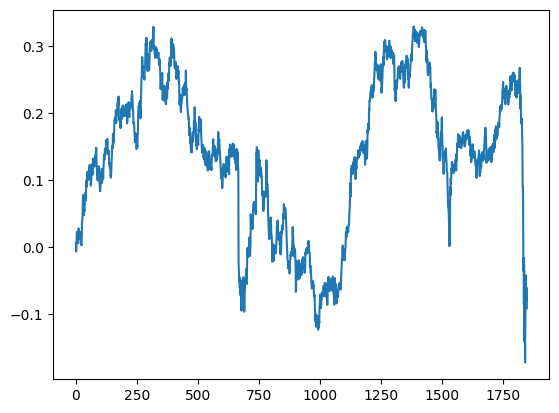

In [74]:
plt.plot(markowitz_returns.cumsum())

## ML portfolio optimization

In [77]:
def ml_portfolio_construction(
    predicted_returns: np.ndarray,
    predicted_volatility = None,
    strategy: str = 'proportional',
    top_k = None,
    **kwargs
) -> np.ndarray:
    """
    Construct portfolio based on ML predictions
    
    Args:
        predicted_returns: Predicted returns for each asset
        predicted_volatility: Optional predicted volatility for risk adjustment
        strategy: 'proportional', 'equal_weight_top_k', 'risk_adjusted'
        top_k: For 'equal_weight_top_k', number of top stocks to select
        **kwargs: Additional arguments for specific strategies
        
    Returns:
        Portfolio weights
    """
    n_assets = len(predicted_returns)
    
    if strategy == 'proportional':
        # Weight proportional to predicted return (only positive predictions)
        positive_returns = np.maximum(predicted_returns, 0)
        if np.sum(positive_returns) > 0:
            weights = positive_returns / np.sum(positive_returns)
        else:
            weights = np.ones(n_assets) / n_assets
            
    elif strategy == 'equal_weight_top_k':
        # Equal weight to top K predicted returns
        if top_k is None:
            top_k = max(5, n_assets // 5)  # Default: top 20%
        
        top_indices = np.argsort(predicted_returns)[-top_k:]
        weights = np.zeros(n_assets)
        weights[top_indices] = 1.0 / top_k
        
    elif strategy == 'risk_adjusted':
        # Weight by return/risk ratio (Sharpe-like weighting)
        if predicted_volatility is None:
            # Use historical volatility as proxy
            predicted_volatility = np.ones(n_assets)
        
        # Avoid division by zero
        predicted_volatility = np.maximum(predicted_volatility, 1e-6)
        
        # Risk-adjusted returns
        risk_adjusted = predicted_returns / predicted_volatility
        
        # Only positive risk-adjusted returns
        positive_ra = np.maximum(risk_adjusted, 0)
        
        if np.sum(positive_ra) > 0:
            weights = positive_ra / np.sum(positive_ra)
        else:
            weights = np.ones(n_assets) / n_assets
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")
    
    return weights

In [78]:
print("="*60)
print("ML-BASED PORTFOLIOS")
print("="*60)

# Strategy 1: Proportional weighting
print("\\n1. Proportional Weighting Strategy:")
ml_prop_returns, ml_prop_weights = construct_rolling_portfolios(
    returns_df,
    predictions_df,
    portfolio_type='ml',
    rebalance_frequency=5,
    strategy='proportional'
)

ml_prop_metrics = calculate_portfolio_metrics(ml_prop_returns)
ml_prop_turnover = calculate_turnover(ml_prop_weights)

print(f"  Sharpe Ratio:     {ml_prop_metrics['sharpe_ratio']:.4f}")
print(f"  Max Drawdown:     {ml_prop_metrics['max_drawdown']:.4f}")
print(f"  Cumulative Return:{ml_prop_metrics['cumulative_return']:.4f}")
print(f"  Turnover:         {ml_prop_turnover:.4f}")

# Strategy 2: Top-K equal weight
print("\\n2. Top-K Equal Weight Strategy (K=5):")
ml_topk_returns, ml_topk_weights = construct_rolling_portfolios(
    returns_df,
    predictions_df,
    portfolio_type='ml',
    rebalance_frequency=5,
    strategy='equal_weight_top_k',
    top_k=5
)

ml_topk_metrics = calculate_portfolio_metrics(ml_topk_returns)
ml_topk_turnover = calculate_turnover(ml_topk_weights)

print(f"  Sharpe Ratio:     {ml_topk_metrics['sharpe_ratio']:.4f}")
print(f"  Max Drawdown:     {ml_topk_metrics['max_drawdown']:.4f}")
print(f"  Cumulative Return:{ml_topk_metrics['cumulative_return']:.4f}")
print(f"  Turnover:         {ml_topk_turnover:.4f}")

print("="*60)

ML-BASED PORTFOLIOS
\n1. Proportional Weighting Strategy:
  Sharpe Ratio:     0.5082
  Max Drawdown:     -0.3806
  Cumulative Return:2.7416
  Turnover:         0.1273
\n2. Top-K Equal Weight Strategy (K=5):
  Sharpe Ratio:     0.9225
  Max Drawdown:     -0.3424
  Cumulative Return:4.4459
  Turnover:         0.1143


### Proportional Weighting strategy cumulative returns

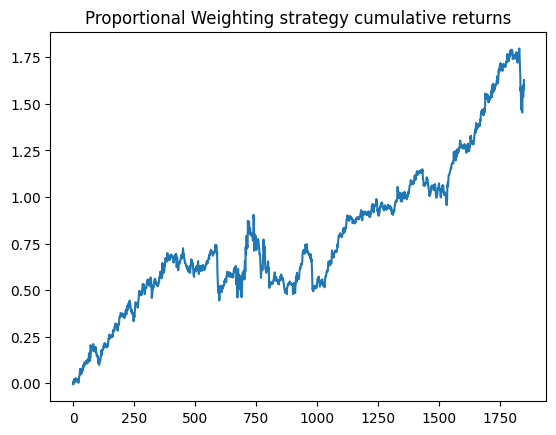

In [82]:
plt.plot(ml_prop_returns.cumsum())
plt.title('Proportional Weighting strategy cumulative returns')
plt.show()

### TopK strategy cumulative returns

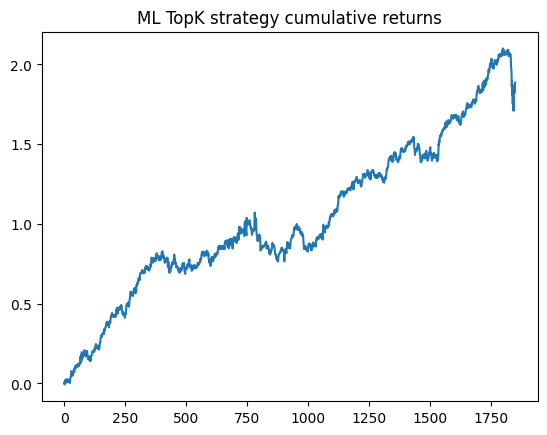

In [88]:
plt.plot(ml_topk_returns.cumsum())
plt.title('ML TopK strategy cumulative returns')
plt.show()